## Exploratory Data Analysis <a id='1_Exploratory_Data_Analysis'></a>

### 1.1 Table of Contents <a id='1.1_Table_of_Contents'></a>
* [1 Exploratory Data Analysis - West Nile Virus](#1_Exploratory_Data_Analysis)
     * [1.1 Table of Contents](#1.1_Table_of_Contents)
     * [1.2 Imports & Loads](#1.2_Imports)
     * [1.3 Train Data](#1.3_Train_Data)
         * [1.3.1 Distance Split](#1.3.1_Distance_Split)

### 1.2 Imports & Loads <a id='1.2_Imports'></a>

In [1]:
# Import from Data Wrangling Notebook
%store -r station
%store -r spray
%store -r train

In [2]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import shap
import traceback
import re
import string
import warnings
from pandas import Series

### 1.3 Trap Exploring <a id='1.3_Train_Data'></a>

#### 1.3.1 Time <a id='1.3.1_Distance_Split'></a>

Using the barplot function without specifying `order` is likely to produce an incorrect plot.


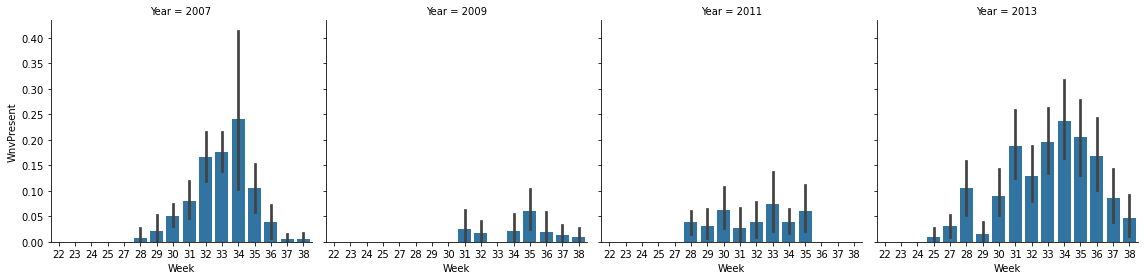

In [3]:
g = sns.FacetGrid(train, col="Year", height=4)
g.map(sns.barplot, "Week", "WnvPresent")

Clearly some peaks around week 34 in 2007 and 2013, while 2009 and 2011 are more subdued. More to investigate here.

In [4]:
species = train[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum().reset_index()
print(species)

                  Species  NumMosquitos  WnvPresent
0         CULEX ERRATICUS             7           0
1           CULEX PIPIENS         44671         184
2  CULEX PIPIENS/RESTUANS         66268         225
3          CULEX RESTUANS         23431          48
4        CULEX SALINARIUS           145           0
5          CULEX TARSALIS             7           0
6         CULEX TERRITANS           510           0


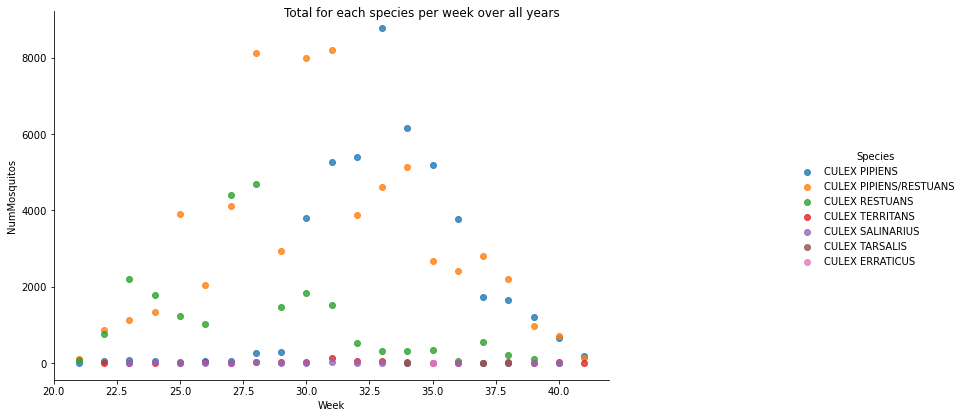

In [5]:
# total mosquitos in a given week from all years.
df_temp = train.groupby(['Week','Species'], as_index=False).sum().reindex()

fg = sns.lmplot(data=df_temp, x = 'Week', y='NumMosquitos', hue='Species', fit_reg=False);
fg.fig.set_figheight(6)
fg.fig.set_figwidth(15)
fg.fig.suptitle("Total for each species per week over all years");

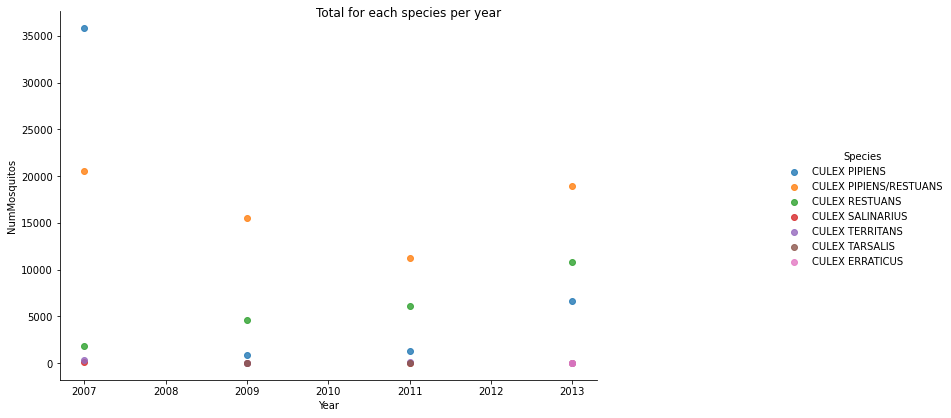

In [6]:
# total mosquitos in a given year
df_temp = train.groupby(['Year','Species'], as_index=False).sum().reindex()

fg = sns.lmplot(data=df_temp, x='Year', y='NumMosquitos', hue='Species', fit_reg=False);
fg.fig.set_figheight(6)
fg.fig.set_figwidth(15)
fg.fig.suptitle("Total for each species per year");

Interesting, we can see a clear u shape for both pip/res and pip species and a slow growth of res. Hypothesis: the res type can survive in a wider range of conditions so is active for longer, but pip is overall best suited for propagating in the local environment and is more prone to carrying WNV

In [7]:
# looking more closely at just the infected species
train_temp = train.loc[train['Species'].isin(['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS'])]

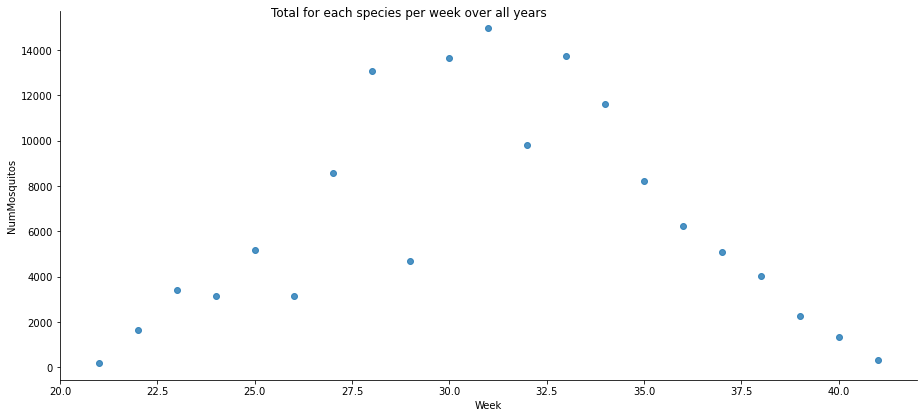

In [8]:
# total mosquitos in a given week from all years, really just another way of looking at our first chart but only with wnv ones
df_temp = train_temp.groupby(['Week'], as_index=False).sum().reindex()

fg = sns.lmplot(data=df_temp, x = 'Week', y='NumMosquitos', fit_reg=False);
fg.fig.set_figheight(6)
fg.fig.set_figwidth(15)
fg.fig.suptitle("Total for each species per week over all years");

Text(0, 0.5, '')

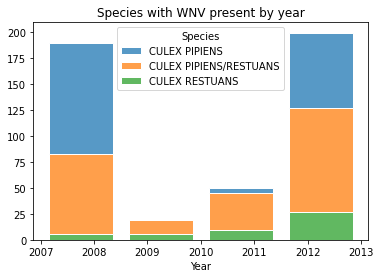

In [9]:
df_temp = train_temp.groupby(['Year', 'Species'])['WnvPresent'].sum().unstack().fillna(0)

ax = sns.histplot(
    train_temp,
    x='Year',
    weights='WnvPresent',
    hue='Species',
    multiple='stack',
    edgecolor='white',
    shrink=0.8,
    bins=4
)

ax.set_title('Species with WNV present by year')
ax.set_ylabel(None)

In [10]:
Week_count = train.Week.value_counts()
Week_wnv=train.groupby('Week')['WnvPresent'].sum().sort_values(ascending=False)
Week_count=Week_count.to_frame().join(Week_wnv.to_frame())
Week_count = Week_count.rename(columns={'Week': 'Sample', 'WnvPresent': 'Wnv_sample'})
Week_count['Wnv_percent']=Week_count.Wnv_sample*100/Week_count.Sample
Week_count.reset_index(inplace=True)
Week_count=Week_count.rename(columns={'index': 'Week'})
Week_count.set_index(["Week"], inplace = True)
Week_count.sort_values(by='Wnv_percent',ascending=False)

,Sample,Wnv_sample,Wnv_percent
Week,,,
34,747,111,14.859438
33,514,75,14.591440
35,297,40,13.468013
36,289,38,13.148789
32,552,44,7.971014
31,753,52,6.905710
30,682,29,4.252199
37,685,26,3.795620
38,482,12,2.489627


Weeks 21 to 24 have never had WNV as well as week 41, we can cut thoseto reduce the count of non-wnv samples

### 1.4 Weather Exploring <a id='1.4_Weather'></a>

#### 1.4.1 Tempature

In [11]:
temp_col = ['AvgSpeed', 'Cool', 'Heat', 'PrecipTotal', 'ResultDir',
       'ResultSpeed', 'SeaLevel', 'StnPressure', 'Sunrise',
       'Sunset', 'WetBulb', 'low_vis', 'rain', 'TmaxC', 'TminC', 'TavgC',
       'DewPointC', 'RHmax', 'RHmin', 'RHavg', 'Week', 'Year']
narrow_station = station[temp_col]

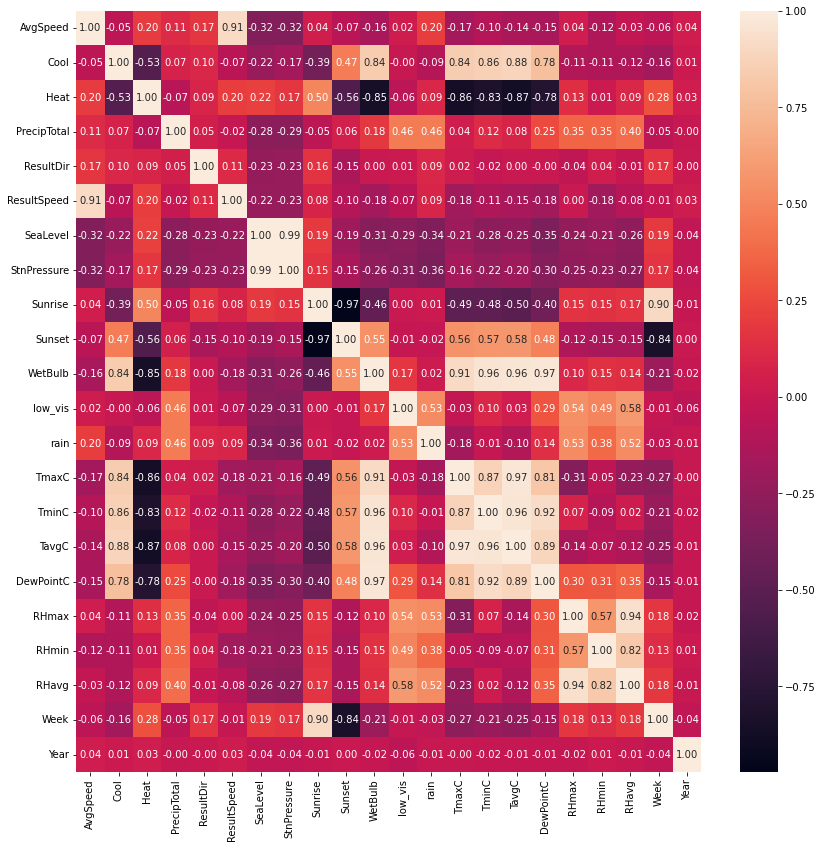

In [12]:
plt.subplots(figsize=(14,14))

corr = narrow_station.corr(method='pearson')

ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")
plt.savefig('heatmap.png',dpi=600)

There's a strong correllation between tempatures as to be expected, but also with the DewPoint, which is also expected. As well as the Relative Humidity Min/Max/Avg among itself. Cool and Heat respectively correlated and negatively correlated with T. Sunset and Sunrise has correlations with the week of the year, and StnPressure has correlations with sea level. Heatbulb has a negative correlation with heat. Nothing suprising.

### Feature Selection

In [13]:
station.columns

Index(['AvgSpeed', 'Cool', 'Heat', 'PrecipTotal', 'ResultDir', 'ResultSpeed',
       'SeaLevel', 'StnPressure', 'Sunrise', 'Sunset', 'WetBulb', 'low_vis',
       'rain', 'TmaxC', 'TminC', 'TavgC', 'DewPointC', 'RHmax', 'RHmin',
       'RHavg', 'AvgSpeed_d7', 'Cool_d7', 'DewPoint_d7', 'Heat_d7',
       'PrecipTotal_d7', 'ResultDir_d7', 'ResultSpeed_d7', 'SeaLevel_d7',
       'StnPressure_d7', 'Sunrise_d7', 'Sunset_d7', 'WetBulb_d7', 'low_vis_d7',
       'rain_d7', 'TmaxC_d7', 'TminC_d7', 'TavgC_d7', 'DewPointC_d7',
       'RHmax_d7', 'RHmin_d7', 'RHavg_d7', 'AvgSpeed_d14', 'Cool_d14',
       'DewPoint_d14', 'Heat_d14', 'PrecipTotal_d14', 'ResultDir_d14',
       'ResultSpeed_d14', 'SeaLevel_d14', 'StnPressure_d14', 'Sunrise_d14',
       'Sunset_d14', 'WetBulb_d14', 'low_vis_d14', 'rain_d14', 'TmaxC_d14',
       'TminC_d14', 'TavgC_d14', 'DewPointC_d14', 'RHmax_d14', 'RHmin_d14',
       'RHavg_d14', 'Week', 'Year'],
      dtype='object')

In [14]:
# Drop weather features exhibiting highly corrleated features retaining only one of them

# AvgSpeed will be kept in place of ResultSpeed
# TavgC will be kept in place of all T's
# StnPressure but not sealevel
# RHmax and RHmin, becuase they don't correlate with each other but do with avg
# Dewpoint and Wetbulb will drop becuase they correlate with the above TavgC
temp_cols = ['ResultSpeed', 'ResultSpeed_d7', 'ResultSpeed_d14','TmaxC' ,'TmaxC_d7' ,'TmaxC_d14' ,'TminC' ,'TminC_d7' ,
             'TminC_d14' ,'SeaLevel' ,'SeaLevel_d7' ,'SeaLevel_d14' ,'Sunrise' ,'Sunrise_d7' ,'Sunrise_d14' ,'Sunset' ,
             'Sunset_d7' ,'Sunset_d14' ,'RHavg' ,'RHavg_d7' ,'RHavg_d14' ,'WetBulb' ,'WetBulb_d7' ,'WetBulb_d14' ,'DewPointC' ,
             'DewPointC_d7' ,'DewPointC_d14']

station = station.drop(columns=temp_cols, axis = 1)

station.shape

(1458, 37)

In [15]:
# Before we remove a few other columns some pre-removal for other stuff
# Remove weeks where no virus was observed And not between weeks where virus was ever observed
train = train[train['Week'].values < 41]
train = train[train['Week'].values > 24]
train.Week.unique()

array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 25],
      dtype=int64)

#### Undersampling

In [16]:
train['WnvPresent'].value_counts()

0    7080
1     457
Name: WnvPresent, dtype: int64

In [17]:
#Simple random undersampling, arbitrarily picking 25% for now. To be modified as a HP in the future
train_data = train.sample(frac=1).reset_index(drop=True)

# Split and undersample
wnv_pos = train_data.loc[train_data['WnvPresent'] == 1]
wnv_neg = train_data.loc[train_data['WnvPresent'] == 0][:1828]

# Combine
normal_distributed_data = pd.concat([wnv_pos, wnv_neg])

# Shuffle
train = normal_distributed_data.sample(frac=1, random_state=42)
train.shape

(2285, 9)

In [18]:
# Need to merge before removing time based cols
trainstation = pd.merge(train, station,  how='left', left_on=['Year','Week'], right_on = ['Year','Week'])

In [19]:
#One hotencoding for species and week

trainstation = pd.get_dummies(trainstation, columns=['Species','Week'])

In [21]:
# drop mosquito species without virus
species_no_wnv=['Species_CULEX TERRITANS','Species_CULEX SALINARIUS','Species_CULEX ERRATICUS' ]
trainstation=trainstation.drop(columns=species_no_wnv)
trainstation.columns

Index(['Date', 'Year', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'AvgSpeed', 'Cool', 'Heat', 'PrecipTotal', 'ResultDir',
       'StnPressure', 'low_vis', 'rain', 'TavgC', 'RHmax', 'RHmin',
       'AvgSpeed_d7', 'Cool_d7', 'DewPoint_d7', 'Heat_d7', 'PrecipTotal_d7',
       'ResultDir_d7', 'StnPressure_d7', 'low_vis_d7', 'rain_d7', 'TavgC_d7',
       'RHmax_d7', 'RHmin_d7', 'AvgSpeed_d14', 'Cool_d14', 'DewPoint_d14',
       'Heat_d14', 'PrecipTotal_d14', 'ResultDir_d14', 'StnPressure_d14',
       'low_vis_d14', 'rain_d14', 'TavgC_d14', 'RHmax_d14', 'RHmin_d14',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Week_25', 'Week_26', 'Week_27', 'Week_28',
       'Week_29', 'Week_30', 'Week_31', 'Week_32', 'Week_33', 'Week_34',
       'Week_35', 'Week_36', 'Week_37', 'Week_38', 'Week_39', 'Week_40'],
      dtype='object')

In [22]:
# Drop time and object type cols
dropcols=['Date','Year', 'Trap']
trainstation=trainstation.drop(columns=dropcols)

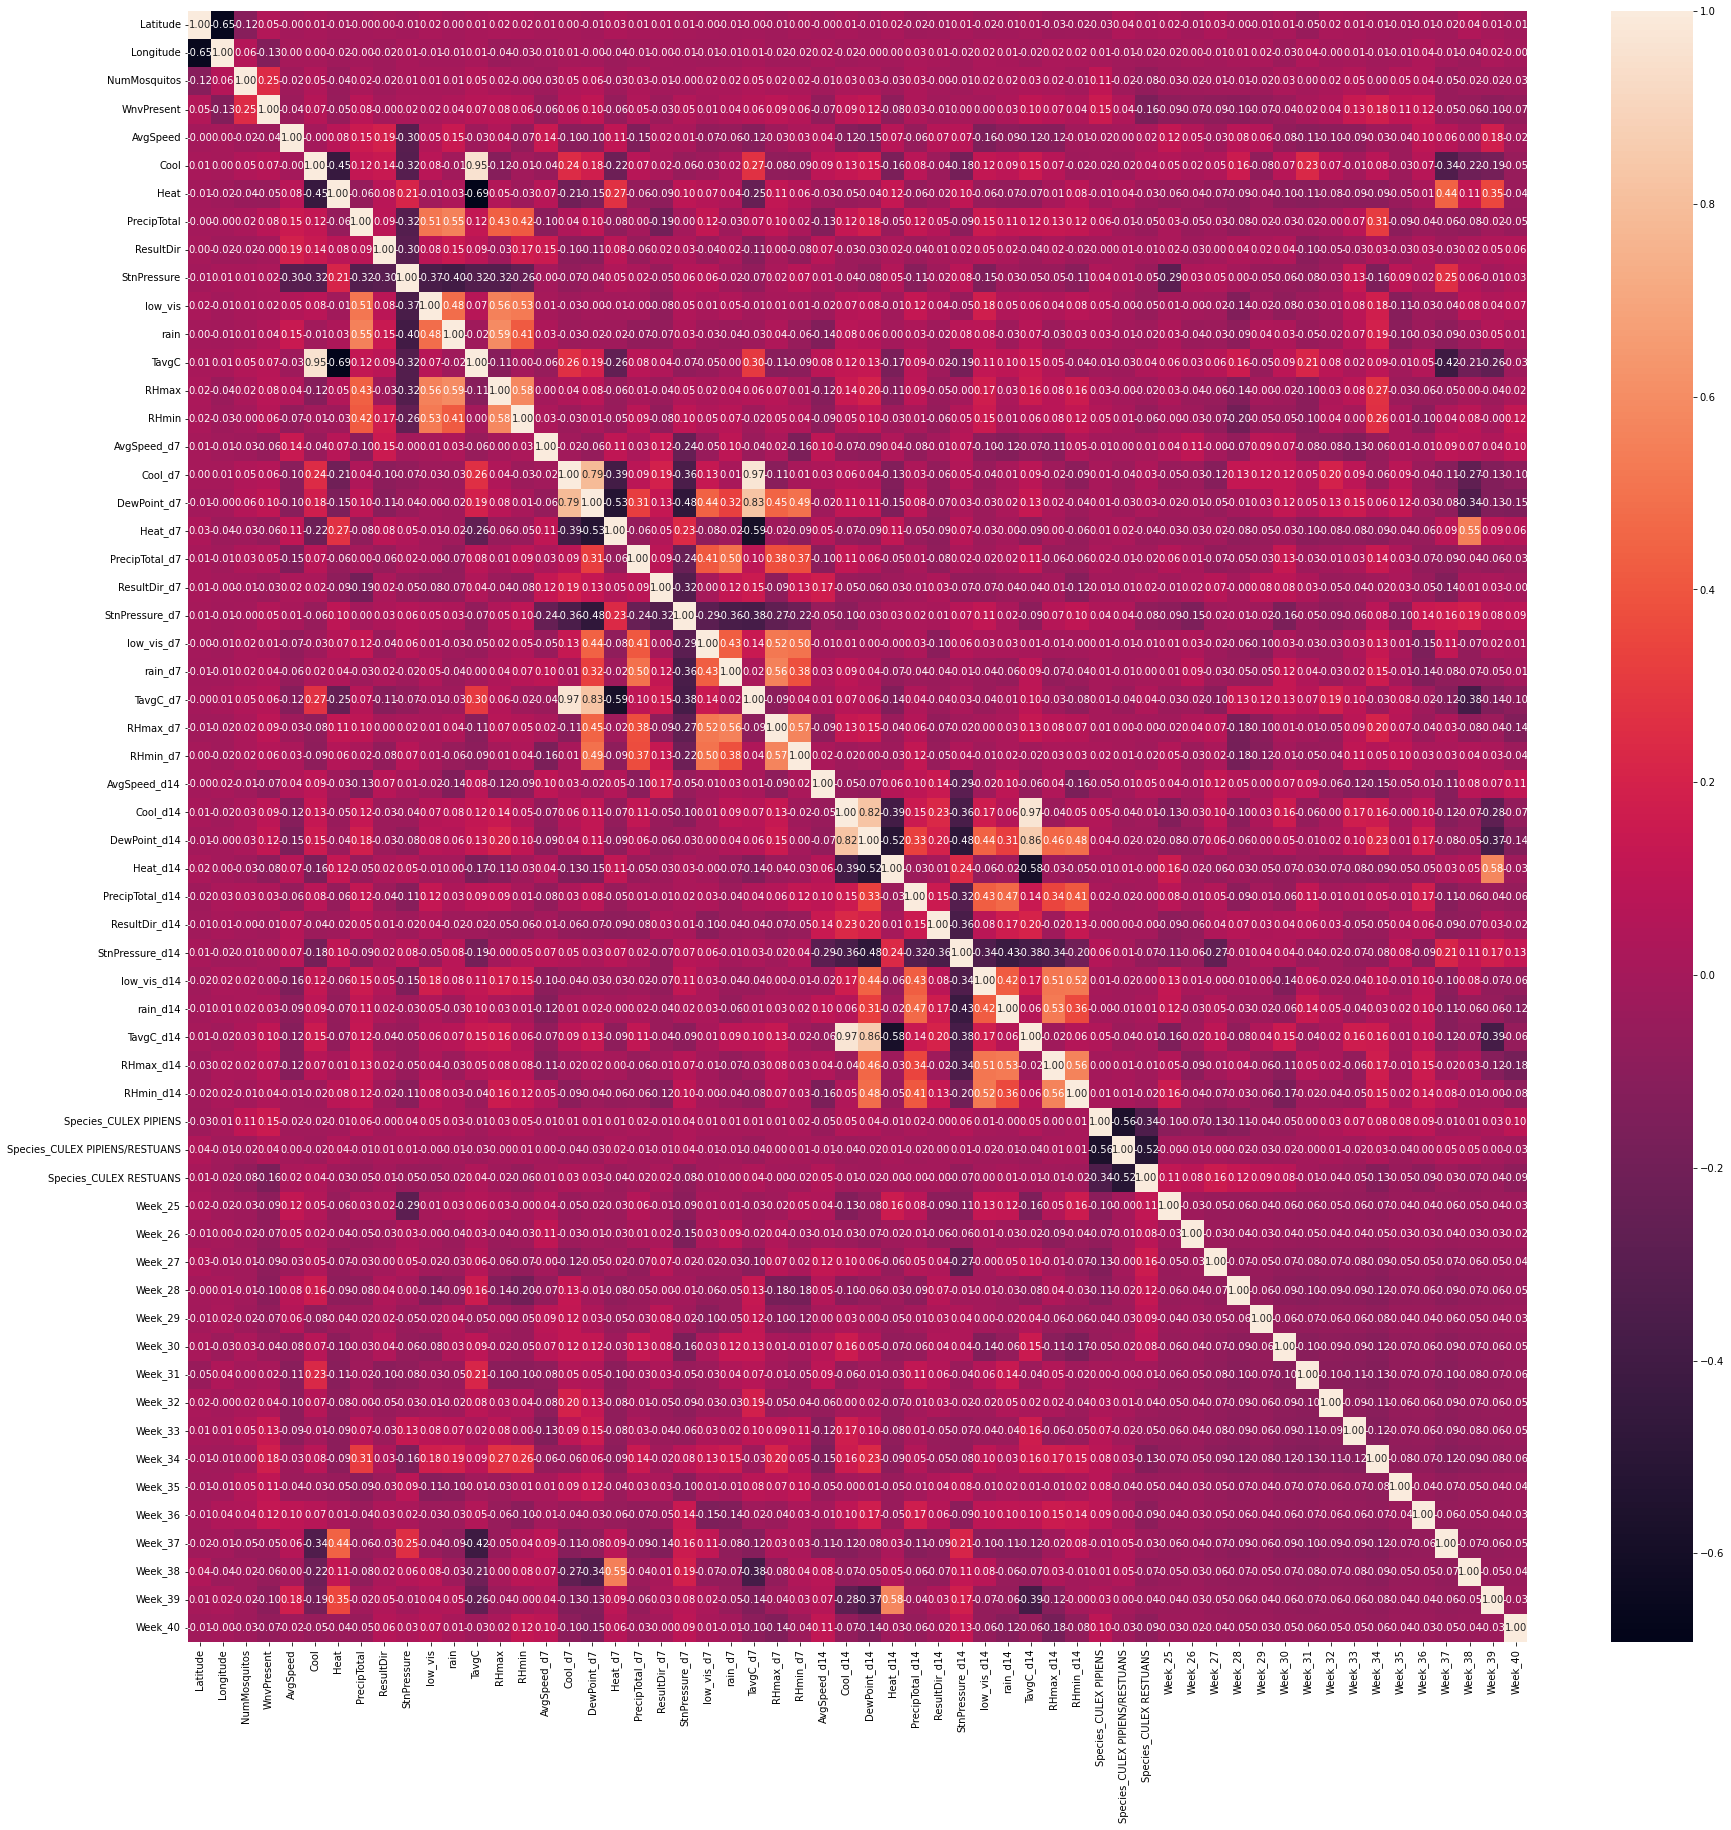

In [23]:
# Last correlation will probably look ugly
plt.subplots(figsize=(30,30))

corr = trainstation.corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

### Train/Test Split

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [25]:
X_train, X_test, y_train, y_test = train_test_split(trainstation.drop(columns='WnvPresent'), trainstation.WnvPresent, 
                                                    test_size=0.25, random_state=42)

In [26]:
#Training virus %
print(y_train.value_counts())
print(y_train.value_counts()/len(y_train))

#Test virus %
print(y_test.value_counts())
print(y_test.value_counts()/len(y_test))

0    9586
1    2410
Name: WnvPresent, dtype: int64
0    0.7991
1    0.2009
Name: WnvPresent, dtype: float64
0    3210
1     789
Name: WnvPresent, dtype: int64
0    0.802701
1    0.197299
Name: WnvPresent, dtype: float64


### Initial Baseline Look

In [27]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

In [28]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
print(model_res)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)

lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=1)
Random Forest: Accuracy=0.877
Random Forest: f1-score=0.871


In [29]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [62]:
X_train, X_test, y_train, y_test = train_test_split(trainstation.drop(columns='WnvPresent'), trainstation.WnvPresent, 
                                                    test_size=0.3, random_state=42)

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11196 entries, 13135 to 7270
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        11196 non-null  float64
 1   Longitude                       11196 non-null  float64
 2   NumMosquitos                    11196 non-null  int64  
 3   AvgSpeed                        11196 non-null  float64
 4   Cool                            11196 non-null  float64
 5   Heat                            11196 non-null  float64
 6   PrecipTotal                     11196 non-null  float64
 7   ResultDir                       11196 non-null  float64
 8   StnPressure                     11196 non-null  float64
 9   low_vis                         11196 non-null  float64
 10  rain                            11196 non-null  float64
 11  TavgC                           11196 non-null  float64
 12  RHmax                        

In [64]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    if len(d2) == 1:
        #print("I am second step ",r, n)
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [65]:
## X_train.to_csv('X_train.csv')
## y_train.to_csv('y_train.csv')

In [66]:
## X_train = pd.read_csv('X_train.csv')
## y_train = pd.read_csv('y_train.csv')

In [67]:
# final_iv, IV = data_vars(X_train, y_train)

In [68]:
X_train.head()

,Latitude,Longitude,NumMosquitos,AvgSpeed,Cool,Heat,PrecipTotal,ResultDir,StnPressure,low_vis,...,Week_31,Week_32,Week_33,Week_34,Week_35,Week_36,Week_37,Week_38,Week_39,Week_40
13135,41.797616,-87.797894,1,6.55,16.5,0.0,0.0000,24.5,29.285,0.5,...,1,0,0,0,0,0,0,0,0,0
10416,41.759346,-87.745602,6,5.80,7.5,0.0,0.6950,16.0,29.180,1.0,...,0,0,0,1,0,0,0,0,0,0
3231,41.970248,-87.787992,1,11.95,12.5,0.0,0.0000,21.5,29.205,1.0,...,0,0,0,0,0,0,0,1,0,0
10650,41.822536,-87.666343,7,9.60,7.5,0.0,0.0305,34.5,29.310,0.0,...,0,0,0,0,0,1,0,0,0,0
12413,42.008314,-87.777921,14,11.05,5.0,0.0,0.0000,30.0,29.255,0.0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# final_iv

In [70]:
# IV

In [71]:
# features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
# X2 = X_train[features]
# display(X2.shape)
# X2.head()

In [72]:
#display(X2.shape[1])
#for i in range(X2.shape[1]):
#    print((i, variance_inflation_factor(X2.values, i) ))

In [73]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X_train._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Week_34 with VIF of 204326.350456
Iteration # 2
Removing Longitude with VIF of 639483.591905
Iteration # 3
Removing Latitude with VIF of 115214.071764
Iteration # 4
Removing StnPressure with VIF of 91743.578744
Iteration # 5
Removing StnPressure_d7 with VIF of 76796.413956
Iteration # 6
Removing DewPoint_d14 with VIF of 75372.389725
Iteration # 7
Removing DewPoint_d7 with VIF of 54587.831158
Iteration # 8
Removing TavgC with VIF of 42389.212513
Iteration # 9
Removing StnPressure_d14 with VIF of 8052.463817
Iteration # 10
Removing TavgC_d14 with VIF of 3762.750698
Iteration # 11
Removing TavgC_d7 with VIF of 992.533317
Iteration # 12
Removing RHmin_d14 with VIF of 258.944753
Iteration # 13
Removing RHmin_d7 with VIF of 238.743694
Iteration # 14
Removing RHmin with VIF of 211.010690
Iteration # 15
Removing RHmax_d14 with VIF of 100.155452
Iteration # 16
Removing RHmax with VIF of 70.736189
Iteration # 17
Removing RHmax_d7 with VIF of 48.330114
Iteration # 18
Removi

In [74]:
X_train=final_df
display(len(X_train.columns))
display(X_train.columns)
X_train.head()

36

Index(['NumMosquitos', 'Cool', 'Heat', 'PrecipTotal', 'ResultDir', 'low_vis',
       'rain', 'Cool_d7', 'Heat_d7', 'PrecipTotal_d7', 'ResultDir_d7',
       'low_vis_d7', 'rain_d7', 'Cool_d14', 'Heat_d14', 'PrecipTotal_d14',
       'ResultDir_d14', 'low_vis_d14', 'rain_d14', 'Species_CULEX PIPIENS',
       'Species_CULEX RESTUANS', 'Week_25', 'Week_26', 'Week_27', 'Week_28',
       'Week_29', 'Week_30', 'Week_31', 'Week_32', 'Week_33', 'Week_35',
       'Week_36', 'Week_37', 'Week_38', 'Week_39', 'Week_40'],
      dtype='object')

,NumMosquitos,Cool,Heat,PrecipTotal,ResultDir,low_vis,rain,Cool_d7,Heat_d7,PrecipTotal_d7,...,Week_30,Week_31,Week_32,Week_33,Week_35,Week_36,Week_37,Week_38,Week_39,Week_40
13135,1,16.5,0.0,0.0000,24.5,0.5,0.0,9.5,0.0,0.5400,...,0,1,0,0,0,0,0,0,0,0
10416,6,7.5,0.0,0.6950,16.0,1.0,1.0,9.0,0.0,0.0000,...,0,0,0,0,0,0,0,0,0,0
3231,1,12.5,0.0,0.0000,21.5,1.0,0.0,0.0,8.5,0.0000,...,0,0,0,0,0,0,0,1,0,0
10650,7,7.5,0.0,0.0305,34.5,0.0,0.5,3.5,0.0,0.0005,...,0,0,0,0,0,1,0,0,0,0
12413,14,5.0,0.0,0.0000,30.0,0.0,0.0,11.5,0.0,0.4100,...,0,0,0,0,0,0,0,0,0,0
